# GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [2]:
import xml.etree.ElementTree as ET
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from tqdm import tqdm

import tensorflow as tf
#from google.colab import drive
import numpy as np
import pandas as pd
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import tensorflow_hub as hub
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
import numpy as np
import math
import re
import pandas as pd #cargar los dataset
#from bs4 import BeautifulSoup
import random #mezclar datos
import tensorflow as tf
import tensorflow_hub as hub # para obtener el modelo pre-entrenado de BERT
from tensorflow.keras import layers
import bert
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import random
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 3 Datasets : ISEAR, MELD y IEMOCAP

## Datasets

### ISEAR

In [125]:
import pandas as pd


isear = pd.read_excel('E:\des\DATASET TEXT\ISEAR.xlsx')


print(isear.head())

      ID  CITY  COUN  SUBJ  SEX  AGE  RELI  PRAC  FOCC  MOCC  ...  SELF  RELA  \
0  11001     1     1     1    1   33     1     2     6     1  ...     3     3   
1  11001     1     1     1    1   33     1     2     6     1  ...     2     2   
2  11001     1     1     1    1   33     1     2     6     1  ...     2     1   
3  11001     1     1     1    1   33     1     2     6     1  ...     1     1   
4  11001     1     1     1    1   33     1     2     6     1  ...     0     2   

   VERBAL  NEUTRO   Field1  Field3  Field2   MYKEY  \
0       2       0      joy       4       3  110011   
1       0       0     fear       3       2  110012   
2       0       0    anger       1       3  110013   
3       0       2  sadness       4       4  110014   
4       0       0  disgust       4       4  110015   

                                                 SIT  STATE  
0  During the period of falling in love, each tim...      1  
1         When I was involved in a traffic accident.      1  
2 

In [126]:
isearDataset = isear.iloc[:, [40,36]]
isearDataset = isearDataset.rename(columns={'Field1': 'label', 'SIT': 'texto'})
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness
7663,I was at home and I heard a loud sound of spit...,disgust
7664,I did not do the homework that the teacher had...,shame


In [127]:
def eliminarAcentos(texto):
    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    return texto
isearDataset['texto'] = isearDataset['texto'].apply(eliminarAcentos)

In [128]:
isearDataset = isearDataset.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Reemplazar nombres de datos
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'shame'].index) #Eliminar nombres de datos de emociones que no se ocupan
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guilt'].index)
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guit'].index)
isearDataset = isearDataset.reset_index(drop=True)
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
5472,I received a letter from a distant friend.,happy
5473,My parents were out and I was the eldest at ho...,fear
5474,Two years back someone invited me to be the tu...,angry
5475,I had taken the responsibility to do something...,sad


### MELD

In [129]:
dfMeld=pd.read_csv('meld_train.csv')

label = dfMeld['Emotion']
text = dfMeld['Utterance']

data = {
    'texto' : text.tolist(),
    'label' : label.tolist()
}

dfMeld= pd.DataFrame(data)

In [130]:
dfMeld = dfMeld.replace(to_replace=['joy', 'sadness', 'anger'], value=['happy', 'sad', 'angry'])
dfMeld

,texto,label
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


In [131]:
def eliminarAcentos(texto):
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")
    return texto
dfMeld['texto'] = dfMeld['texto'].apply(eliminarAcentos)
dfMeld

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


### IEMOCAP

In [132]:
iemocapDataset = pd.read_csv('df_filters.csv')
iemocapDataset

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [133]:
iemocapDataset['Emoción'].unique()

array(['neutral', 'angry', 'sad', 'happy', 'surprise', 'fear', 'disgust'],
      dtype=object)

In [134]:
iemocapDataset = iemocapDataset.rename(columns={'Emoción': 'label', 'Texto':'texto'})
iemocapDataset

,texto,label
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


### Concatenate

In [135]:
dftodo = pd.concat([dfMeld, isearDataset,iemocapDataset])
dftodo = dftodo.reset_index(drop=True)
dftodo

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
20098,oh! Marry you again? I wouldn't marry you agai...,angry
20099,Beast,angry
20100,You're a wicked little vampire. And I pray to ...,angry
20101,Brute,angry


In [136]:
dftodo['label'].value_counts()

label
neutral     6417
happy       3432
angry       3308
sad         2862
fear        1403
disgust     1369
surprise    1312
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='Count'>

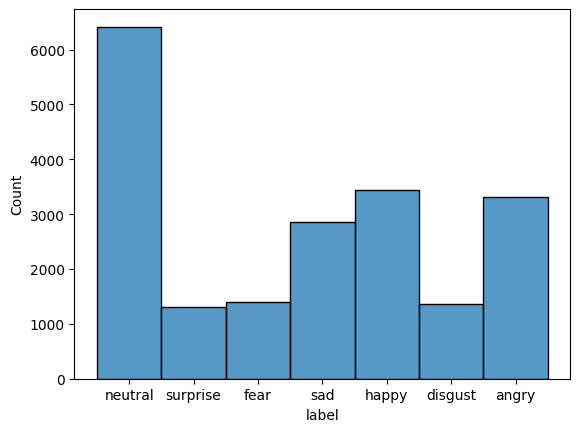

In [137]:
sns.histplot(x=dftodo['label'])

In [138]:
dftodo[20:35]

,texto,label
20,"Yeah, sure!",neutral
21,"Hey, Mon.",neutral
22,Hey-hey-hey. You wanna hear something that sucks.,neutral
23,Do I ever.,happy
24,Chris says they're closing down the bar.,sad
25,No way!,surprise
26,"Yeah, apparently they're turning it into some ...",neutral
27,Just coffee! Where are we gonna hang out now?,disgust
28,Got me.,sad
29,Can I get a beer.,neutral


## Data Balacing

### RandomOverSampler

In [17]:
random = RandomOverSampler(random_state=42)

X_resampled, y_resampled = random.fit_resample(dftodo[['texto']], dftodo['label'])

# Crear un nuevo dataframe con los datos sobremuestreados
df_resampled = pd.DataFrame(X_resampled, columns=['texto'])
df_resampled['label'] = y_resampled
df_resampled

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
44914,"Oh my God, I remember now! We were playing chess!",surprise
44915,What?! What else did he say?,surprise
44916,What? Why?,surprise
44917,How do you lose a suitcase? A huge suitcase?,surprise


In [37]:
df_resampled['label'].value_counts()

label
neutral     6417
surprise    6417
fear        6417
sad         6417
happy       6417
disgust     6417
angry       6417
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='Count'>

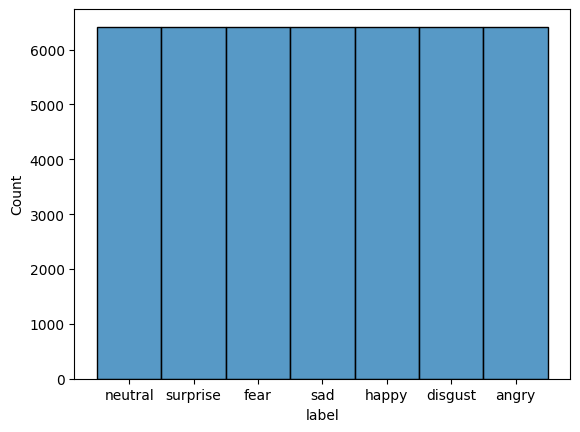

In [21]:
sns.histplot(x=df_resampled['label'])

### Similitud

In [139]:
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as naw
from tqdm import tqdm

aug = naw.SynonymAug(aug_src='wordnet')

conteo_clases = dftodo['label'].value_counts()

clase_mayoritaria = conteo_clases.idxmax()
conteo_mayoritario = conteo_clases.max()

df_balanceado = pd.DataFrame(columns=['texto', 'label', 'original'])


for clase in tqdm(dftodo['label'].unique()):
    df_clase = dftodo[dftodo['label'] == clase]
    
    if clase == clase_mayoritaria:
        df_clase['original'] = df_clase['texto']  
        df_balanceado = pd.concat([df_balanceado, df_clase])
    else:
        datos_faltantes = conteo_mayoritario - len(df_clase)
        

        datos_sinteticos = df_clase.sample(datos_faltantes, replace=True)
        datos_sinteticos['original'] = datos_sinteticos['texto']  
        datos_sinteticos['texto'] = datos_sinteticos['texto'].apply(aug.augment) 
        
        df_balanceado = pd.concat([df_balanceado, df_clase, datos_sinteticos])

c:\Users\bryan\anaconda3\envs\GPU_IEMOCAP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\bryan\AppData\Local\Temp\ipykernel_1336\3238353294.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clase['original'] = df_clase['texto']
100%|██████████| 7/7 [00:53<00:00,  7.59s/it]


In [140]:
df_balanceado['label'].value_counts()

label
neutral     6417
surprise    6417
fear        6417
sad         6417
happy       6417
disgust     6417
angry       6417
Name: count, dtype: int64

In [141]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado

,texto,label,original
0,also I was the point person on my company's tr...,neutral,also I was the point person on my company's tr...
1,You must've had your hands full.,neutral,You must've had your hands full.
2,That I did. That I did.,neutral,That I did. That I did.
3,So let's talk a little bit about your duties.,neutral,So let's talk a little bit about your duties.
4,"Now you'll be heading a whole division, so you...",neutral,"Now you'll be heading a whole division, so you..."
...,...,...,...
44914,[One had too much prep and examinations and Si...,angry,I had too much homework and examinations and I...
44915,[Sob!],angry,Bastard!
44916,"[This is ridiculous. I - I seriously, I don ' ...",angry,"This is ridiculous. I- I seriously, I don't un..."
44917,"[What do you need to coif, contend with him?]",angry,"What do you want to do, argue with him?"


In [142]:
df_balanceado[80:100]

,texto,label,original
80,"Oh, yeah, Bob said there might be flood damage.",neutral,"Oh, yeah, Bob said there might be flood damage."
81,"Yeah, either that, or he has a really big cat.",neutral,"Yeah, either that, or he has a really big cat."
82,"If you said, ""Big lima bean, bubbling up."" Wou...",neutral,"If you said, ""Big lima bean, bubbling up."" Wou..."
83,Rach? What are you doing?,neutral,Rach? What are you doing?
84,It's a diaper commercial.,neutral,It's a diaper commercial.
85,"Hey, you wanna get something to eat or uh, do ...",neutral,"Hey, you wanna get something to eat or uh, do ..."
86,"Uhh, the ball thing.",neutral,"Uhh, the ball thing."
87,Yeah?,neutral,Yeah?
88,"Uhh,",neutral,"Uhh,"
89,What?,neutral,What?


In [144]:
df_resampled = pd.DataFrame({'texto': df_balanceado['texto'], 'label': df_balanceado['label']})
df_resampled

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,"Now you'll be heading a whole division, so you...",neutral
...,...,...
44914,[One had too much prep and examinations and Si...,angry
44915,[Sob!],angry
44916,"[This is ridiculous. I - I seriously, I don ' ...",angry
44917,"[What do you need to coif, contend with him?]",angry


In [145]:
dftodo[20:35]

,texto,label
20,"Yeah, sure!",neutral
21,"Hey, Mon.",neutral
22,Hey-hey-hey. You wanna hear something that sucks.,neutral
23,Do I ever.,happy
24,Chris says they're closing down the bar.,sad
25,No way!,surprise
26,"Yeah, apparently they're turning it into some ...",neutral
27,Just coffee! Where are we gonna hang out now?,disgust
28,Got me.,sad
29,Can I get a beer.,neutral


In [146]:
df_resampled[20:35]

,texto,label
20,He was with her when he wrote this poem.,neutral
21,"Look, 'My vessel so empty with nothing inside.",neutral
22,"Now that I've touched you, you seem emptier st...",neutral
23,Done.,neutral
24,"Ah y'know, this building is on my paper route ...",neutral
25,Oh.,neutral
26,Hi.,neutral
27,Hi.,neutral
28,How'd did it go?,neutral
29,I know.,neutral


In [147]:
df_resampled['texto']

0        also I was the point person on my company's tr...
1                         You must've had your hands full.
2                                  That I did. That I did.
3            So let's talk a little bit about your duties.
4        Now you'll be heading a whole division, so you...
                               ...                        
44914    [One had too much prep and examinations and Si...
44915                                               [Sob!]
44916    [This is ridiculous. I - I seriously, I don ' ...
44917        [What do you need to coif, contend with him?]
44918                         [Made fault in examination.]
Name: texto, Length: 44919, dtype: object

In [150]:
X_resampled.shape

(44919, 1)

In [151]:
y_resampled.shape

(44919,)

## Data Cleansing and transformation

In [152]:
# Descargar el paquete 'averaged_perceptron_tagger' para la lematización pre-entrenada
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [153]:

lemmatizer = WordNetLemmatizer()

# Definir la función para asignar etiquetas POS de WordNet a etiquetas POS de NLTK
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    # Tokenizar el texto y obtener las etiquetas POS
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(texto))
    
    # Mapear las etiquetas POS de NLTK a etiquetas POS de WordNet
    wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]
    
    # Lematizar cada palabra con su etiqueta POS correspondiente
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    
    # Unir las palabras lematizadas para formar el texto lematizado
    lemmatized_text = " ".join(lemmatized_words)

    lemmatized_text = re.sub(r"\s(?=\')", "", lemmatized_text) #Eliminar los espacios que une los apóstrofes
    lemmatized_text = re.sub(r"\s(?=\.)", "", lemmatized_text) #Eliminar los espacios que une los .
    lemmatized_text = re.sub(r"\s(?=\!)", "", lemmatized_text) #Eliminar los espacios que une los !
    lemmatized_text = re.sub(r"\s(?=\?)", "", lemmatized_text) #Eliminar los espacios que une los ?
    
    return lemmatized_text

# Llamado a la función de limpieza
texto_clean = [clean_emotion_text(text) for text in tqdm(df_resampled['texto'])]

100%|██████████| 44919/44919 [01:47<00:00, 418.51it/s]


In [154]:
df_resampled['texto'][0:10]

0    also I was the point person on my company's tr...
1                     You must've had your hands full.
2                              That I did. That I did.
3        So let's talk a little bit about your duties.
4    Now you'll be heading a whole division, so you...
5                                               I see.
6    But there'll be perhaps 30 people under you so...
7                                        Good to know.
8                                We can go into detail
9    All right then, we'll have a definite answer f...
Name: texto, dtype: object

In [155]:
df_resampled['texto'][0]

"also I was the point person on my company's transition from the KL-5 to GR-6 system."

In [156]:
texto_clean[0:10]

["also i be the point person on my company's transition from the kl to gr system.",
 "you must've have your hand full.",
 'that i do. that i do.',
 "so let's talk a little bit about your duty.",
 "now you'll be head a whole division so you'll have a lot of duty.",
 'i see.',
 "but there'll be perhaps people under you so you can dump a certain amount on them.",
 'good to know.',
 'we can go into detail',
 "all right then we'll have a definite answer for you on monday but i think i can say with some confidence you'll fit in well here."]

In [157]:
texto_clean

["also i be the point person on my company's transition from the kl to gr system.",
 "you must've have your hand full.",
 'that i do. that i do.',
 "so let's talk a little bit about your duty.",
 "now you'll be head a whole division so you'll have a lot of duty.",
 'i see.',
 "but there'll be perhaps people under you so you can dump a certain amount on them.",
 'good to know.',
 'we can go into detail',
 "all right then we'll have a definite answer for you on monday but i think i can say with some confidence you'll fit in well here.",
 'absolutely. you can relax',
 'ok!',
 'all right well...',
 'yeah sure!',
 'hey mon.',
 'hey hey hey. you wan na hear something that suck.',
 "yeah apparently they're turn it into some kinda coffee place.",
 'can i get a beer.',
 'hey do you pick a roommate?',
 'be it the italian guy?',
 'he be with her when he write this poem.',
 "look'my vessel so empty with nothing inside.",
 "now that i've touch you you seem empty still.'",
 'do.',
 "ah y'know this b

In [158]:
texto_clean[-1]

'make fault in examination.'

## LabelEncoder

In [159]:
labels = df_resampled['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels)

data_labels = labelEncoder

In [160]:
le.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [161]:
# Obtener los nombres de las clases
class_names = le.classes_

# Obtener los valores numéricos asignados a cada clase
class_values = le.transform(class_names)

# Imprimir los nombres de las clases y sus valores numéricos
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


In [162]:
import pandas as pd


df_final = pd.DataFrame({'texto': texto_clean, 'label': data_labels})


df_final.to_csv('datos_procesados_Balanceados.csv', index=False)


## BERT

### Tokenizer definition

In [163]:
FullTokenizer = bert.bert_tokenization.FullTokenizer #llamada a la instancia de bert libreria para obtener la tokenización.



#Llamado al modelo pre-entrenado de Bert L-12
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1", trainable=False)


#obtener el vocabulario del Hub de bert
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#transformación a minusculas
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#aplicación al tokenizador mediante el vocabulario y transformando las palabras a minusculas
tokenizer = FullTokenizer(vocab_file, do_lower_case)

### Data transformation for bert

In [165]:
#Función para aplicar el token en cada sentencia
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]
  #Se aplica CLS para el inicio de clasificación y SEP para la separación en cada secuencia. Esto lo pide Bert.

#Transforma los tokens en lista de ids para obtener la forma numerica de los datos
def get_ids(tokens):
  return tokenizer.convert_tokens_to_ids(tokens)

#Se aplica la mascara para eliminar los tokens de PAD que son los padding para igualar los valores, igualando el token PAD en 0
def get_mask(tokens):
  return np.char.not_equal(tokens, "[PAD]").astype(int)

#Indica si el token es de la primera frase o segunda fase, agrando 0 o 1 dependiendo de la separación
def get_segments(tokens):
  seg_ids = [] #es una lista que se rellena con el token
  current_seg_ids = 0

  for tok in tokens: #recorre todos los tokens
    seg_ids.append(current_seg_ids)
    if tok == "[SEP]": #si el token es de separación
      current_seg_ids = 1-current_seg_ids #convierte los 1 en 0 y viceversa

  return seg_ids

In [166]:
#Llamada a la función que convierte en tokens
data_inputs = [encode_sentence(sentence) for sentence in texto_clean]

In [167]:
import random

#Se crea una lista mediante la secuencia, su respectivo label y el largo de la frase.
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]


random.shuffle(data_with_len) #Se mezcla los datos de forma aleatoria

valor_maximo=-np.inf

for sent_lab in data_with_len:
    if sent_lab[2]>valor_maximo:
        valor_maximo=sent_lab[2]

#Se genera una tupla, se entrega la secuencia para obtener las ids, mask y segments, Además se agrega el label de la secuencia.
sorted_all = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
               for sent_lab in data_with_len]

In [168]:
valor_maximo

201

In [169]:
sorted_all[0:10]

[([[101,
    1517,
    1165,
    178,
    1129,
    2647,
    2041,
    1120,
    2286,
    1843,
    178,
    3333,
    1106,
    14131,
    1139,
    2555,
    1113,
    170,
    13670,
    1112,
    1869,
    2815,
    1464,
    5307,
    178,
    1341,
    1115,
    1122,
    1129,
    170,
    177,
    19429,
    1611,
    1105,
    178,
    22591,
    1566,
    3737,
    119,
    102],
   array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
   [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0]],
  2),
 ([[101,
    1165,
    12861,
    1295,
    16712,
    1103,
    1413,
    1104,
    1103,
    1505,
    1219,
    1126,
    10592,
    5246,
    119,
    102],
   array([1, 1

In [171]:
sorted_all[24]

([[101, 1177, 1128, 112, 1231, 1817, 4911, 119, 102],
  array([1, 1, 1, 1, 1, 1, 1, 1, 1]),
  [0, 0, 0, 0, 0, 0, 0, 0, 0]],
 5)

In [172]:
len(sorted_all)

44919

### Dataset creation

In [173]:
# Creación del generador, mediante la entrega de la tupla de los datos.
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32)) #La salida es entera de tuplas de los datos transformados int(texto), int(etiqueta)

### Application of padding and batches

In [174]:
BATCH_SIZE = 64
SEQUENCE_LENGTH=300
all_batched = all_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=((3, SEQUENCE_LENGTH), ()),
                                       padding_values=(0, 0))

In [175]:
for i, element in enumerate(all_batched.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(64, 3, 300), dtype=int32, numpy=
array([[[  101,  1517,  1165, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1165, 12861, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1105,  1304, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101, 14863,  1122, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1152,  5080, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,   178,  8264, ...,     0,     0,     0],


In [176]:
first_batch = next(iter(all_batched.take(1)))

primer_valor_primer_batch = first_batch[0][0]  # Acceder al primer elemento del primer lote
print(primer_valor_primer_batch)

tf.Tensor(
[[  101  1517  1165   178  1129  2647  2041  1120  2286  1843   178  3333
   1106 14131  1139  2555  1113   170 13670  1112  1869  2815  1464  5307
    178  1341  1115  1122  1129   170   177 19429  1611  1105   178 22591
   1566  3737   119   102     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0  

### Splitting of train, validation and testing datasets

In [182]:
import math

# Calcular el número total de lotes
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
print("NB_BATCHES totales: ",NB_BATCHES)

# Calcular el número de lotes para validación y prueba
NB_BATCHES_VAL = (NB_BATCHES * 20) // 100
NB_BATCHES_TEST = (NB_BATCHES * 10) // 100
print("NB_BATCHES validacion: ",NB_BATCHES_VAL)
print("NB_BATCHES testeo: ",NB_BATCHES_TEST)
print("NB_BATCHES entrenamiento", NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL))

# Se crea los conjuntos de datos para entrenamiento, validación y prueba
val_dataset = all_batched.take(NB_BATCHES_VAL)
test_dataset = all_batched.skip(NB_BATCHES_VAL).take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_VAL + NB_BATCHES_TEST) 

BUFFER_SIZE = 10000
train_dataset = train_dataset.shuffle(BUFFER_SIZE)


NB_BATCHES totales:  702
NB_BATCHES validacion:  140
NB_BATCHES testeo:  70
NB_BATCHES entrenamiento 492


In [178]:
print("Train size: ", len(list(train_dataset)))
print("Validation size: ", len(list(val_dataset)))
print("Test size: ", len(list(test_dataset)))

Train size:  492
Validation size:  140
Test size:  70


In [183]:
for i, element in enumerate(train_dataset.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(64, 3, 300), dtype=int32, numpy=
array([[[  101, 23998,  1362, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,   170,  6124, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1218,   178, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101,   177,  1306, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1120,   170, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1165,  1141, ...,     0,     0,     0],


In [180]:
for i, element in enumerate(val_dataset.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(64, 3, 300), dtype=int32, numpy=
array([[[  101,  1517,  1165, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1165, 12861, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1105,  1304, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101, 14863,  1122, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1152,  5080, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,   178,  8264, ...,     0,     0,     0],


In [181]:
for i, element in enumerate(test_dataset.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(64, 3, 300), dtype=int32, numpy=
array([[[  101,  1165, 20839, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,   177,  6262, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1165,  1175, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101,  1885,  1869, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1517,   170, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  2100,  1234, ...,     0,     0,     0],


### Definición de datos de testeo

#### MELD

In [ ]:
meld_text = pd.read_csv('test_sent_emo.csv')
meld_text = meld_text.iloc[:,[1,3]]
meld_text = meld_text.rename(columns={'Utterance':'texto'})
meld_text['Emotion'] = meld_text['Emotion'].replace(['anger', 'joy', 'sadness'], ['angry', 'happy', 'sad'])
meld_text

,texto,Emotion
0,Why do all youre coffee mugs have numbers on ...,surprise
1,Oh. Thats so Monica can keep track. That way ...,angry
2,Y'know what?,neutral
3,"Come on, Lydia, you can do it.",neutral
4,Push!,happy
...,...,...
2605,"Yeah, I mean, come on Ross, no one will even n...",neutral
2606,They’re not listening too me?,surprise
2607,Of course they’re listening to you! Everybody ...,neutral
2608,Monica you really think I should try this phas...,neutral


In [ ]:
def eliminarAcentos(texto):
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")
    return texto
meld_text['texto'] = meld_text['texto'].apply(eliminarAcentos)
meld_text

,texto,Emotion
0,Why do all you're coffee mugs have numbers on ...,surprise
1,Oh. That's so Monica can keep track. That way ...,angry
2,Y'know what?,neutral
3,"Come on, Lydia, you can do it.",neutral
4,Push!,happy
...,...,...
2605,"Yeah, I mean, come on Ross, no one will even n...",neutral
2606,They’re not listening too me?,surprise
2607,Of course they’re listening to you! Everybody ...,neutral
2608,Monica you really think I should try this phas...,neutral


In [ ]:
# Descargar el paquete 'averaged_perceptron_tagger' para la lematización pre-entrenada
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:

lemmatizer = WordNetLemmatizer()

# Definir la función para asignar etiquetas POS de WordNet a etiquetas POS de NLTK
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    # Tokenizar el texto y obtener las etiquetas POS
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(texto))
    
    # Mapear las etiquetas POS de NLTK a etiquetas POS de WordNet
    wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]
    
    # Lematizar cada palabra con su etiqueta POS correspondiente
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    
    # Unir las palabras lematizadas para formar el texto lematizado
    lemmatized_text = " ".join(lemmatized_words)

    lemmatized_text = re.sub(r"\s(?=\')", "", lemmatized_text) #Eliminar los espacios que une los apóstrofes
    lemmatized_text = re.sub(r"\s(?=\.)", "", lemmatized_text) #Eliminar los espacios que une los .
    lemmatized_text = re.sub(r"\s(?=\!)", "", lemmatized_text) #Eliminar los espacios que une los !
    lemmatized_text = re.sub(r"\s(?=\?)", "", lemmatized_text) #Eliminar los espacios que une los ?
    
    return lemmatized_text

# Llamado a la función de limpieza
texto_clean_text = [clean_emotion_text(text) for text in tqdm(meld_text['texto'])]

100%|██████████| 2610/2610 [00:05<00:00, 514.64it/s]


In [ ]:
le_text2 = LabelEncoder()

data_labels_text = le_text2.fit_transform(meld_text['Emotion'])
data_labels_text

array([6, 0, 4, ..., 4, 4, 4])

In [ ]:
le_text2.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [ ]:
#Función para aplicar el token en cada sentencia
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]
  #Se aplica CLS para el inicio de clasificación y SEP para la separación en cada secuencia. Esto lo pide Bert.

#Transforma los tokens en lista de ids para obtener la forma numerica de los datos
def get_ids(tokens):
  return tokenizer.convert_tokens_to_ids(tokens)

#Se aplica la mascara para eliminar los tokens de PAD que son los padding para igualar los valores, igualando el token PAD en 0
def get_mask(tokens):
  return np.char.not_equal(tokens, "[PAD]").astype(int)

#Indica si el token es de la primera frase o segunda fase, agrando 0 o 1 dependiendo de la separación
def get_segments(tokens):
  seg_ids = [] #es una lista que se rellena con el token
  current_seg_ids = 0

  for tok in tokens: #recorre todos los tokens
    seg_ids.append(current_seg_ids)
    if tok == "[SEP]": #si el token es de separación
      current_seg_ids = 1-current_seg_ids #convierte los 1 en 0 y viceversa

  return seg_ids

In [ ]:
data_inputs_text = [encode_sentence(sent) for sent in texto_clean_text]

In [ ]:
sent_label = [[sent_text, data_labels_text[i]] 
              for i, sent_text in enumerate(data_inputs_text)]

sorted_all_text = [([get_ids(sent_lab_text[0]),
                    get_mask(sent_lab_text[0]),
                    get_segments(sent_lab_text[0])],
                    sent_lab_text[1]) for sent_lab_text in sent_label]

In [ ]:
dataset_text = tf.data.Dataset.from_generator(lambda: sorted_all_text, output_types=(tf.int32, tf.int32))

In [ ]:
dataset_text_batch = dataset_text.padded_batch(BATCH_SIZE,
                                               padded_shapes=((3,SEQUENCE_LENGTH), ()),
                                               padding_values=(0,0))

#### IEMOCAP

In [ ]:
iemocap_text = pd.read_csv('df_filters.csv')
iemocap_text

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [ ]:
def eliminarAcentos(texto):
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")
    return texto
iemocap_text['Texto'] = iemocap_text['Texto'].apply(eliminarAcentos)
iemocap_text

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [ ]:
iemocap_text[250:290]

,Texto,Emoción
250,How do you know he's even thinking about it?,neutral
251,It's got that about it.,angry
252,"What is going on here, Joe?",angry
253,She is not his girl. She knows she's not.,angry
254,Then why is she still single? New York is full...,angry
255,How do you know why she waited?,neutral
256,"Because she knows what I know, that's why. She...",angry
257,Nobody in this house dares take away her faith...,angry
258,I want you to-- I want you to act like he is c...,angry
259,I won't stand for any nonsense.,angry


In [ ]:
iemocap_text[0:10]

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
5,I don't understand why this is so complicated ...,angry
6,"Clearly. You know, do you have like a supervis...",neutral
7,Yeah. Do you want to see my supervisor? Huh? Y...,angry
8,Did you get the mail? So you saw my letter?,sad
9,Yeah. I know.,sad


In [ ]:
# Descargar el paquete 'averaged_perceptron_tagger' para la lematización pre-entrenada
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()

# Definir la función para asignar etiquetas POS de WordNet a etiquetas POS de NLTK
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    # Tokenizar el texto y obtener las etiquetas POS
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(texto))
    
    # Mapear las etiquetas POS de NLTK a etiquetas POS de WordNet
    wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]
    
    # Lematizar cada palabra con su etiqueta POS correspondiente
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    
    # Unir las palabras lematizadas para formar el texto lematizado
    lemmatized_text = " ".join(lemmatized_words)

    lemmatized_text = re.sub(r"\s(?=\')", "", lemmatized_text) #Eliminar los espacios que une los apóstrofes
    lemmatized_text = re.sub(r"\s(?=\.)", "", lemmatized_text) #Eliminar los espacios que une los .
    lemmatized_text = re.sub(r"\s(?=\!)", "", lemmatized_text) #Eliminar los espacios que une los !
    lemmatized_text = re.sub(r"\s(?=\?)", "", lemmatized_text) #Eliminar los espacios que une los ?
    
    return lemmatized_text

# Llamado a la función de limpieza
texto_clean_text_iemocap = [clean_emotion_text(text) for text in tqdm(iemocap_text['Texto'])]

  0%|          | 0/4637 [00:00<?, ?it/s]

100%|██████████| 4637/4637 [00:09<00:00, 464.34it/s]


In [ ]:
texto_clean_text_iemocap[0:10]

['excuse me.',
 'yeah.',
 'be there a problem?',
 "well what's the problem? let me change it.",
 "that's out of control.",
 "i do n't understand why this be so complicate for people when they get here. it's just a simple form. i just need an id.",
 'clearly. you know do you have like a supervisor or something?',
 "yeah. do you want to see my supervisor? huh? yeah. do you want to see my supervisor? fine. i'll be right back.",
 'do you get the mail? so you saw my letter?',
 'yeah. i know.']

In [ ]:
le_text3 = LabelEncoder()

data_labels_text_iemocap = le_text3.fit_transform(iemocap_text['Emoción'])
data_labels_text_iemocap

array([4, 4, 4, ..., 0, 0, 0])

In [ ]:
le_text3.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [ ]:
#Función para aplicar el token en cada sentencia
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]
  #Se aplica CLS para el inicio de clasificación y SEP para la separación en cada secuencia. Esto lo pide Bert.

#Transforma los tokens en lista de ids para obtener la forma numerica de los datos
def get_ids(tokens):
  return tokenizer.convert_tokens_to_ids(tokens)

#Se aplica la mascara para eliminar los tokens de PAD que son los padding para igualar los valores, igualando el token PAD en 0
def get_mask(tokens):
  return np.char.not_equal(tokens, "[PAD]").astype(int)

#Indica si el token es de la primera frase o segunda fase, agrando 0 o 1 dependiendo de la separación
def get_segments(tokens):
  seg_ids = [] #es una lista que se rellena con el token
  current_seg_ids = 0

  for tok in tokens: #recorre todos los tokens
    seg_ids.append(current_seg_ids)
    if tok == "[SEP]": #si el token es de separación
      current_seg_ids = 1-current_seg_ids #convierte los 1 en 0 y viceversa

  return seg_ids

In [ ]:
data_inputs_text_iemocap = [encode_sentence(sent) for sent in texto_clean_text_iemocap]

In [ ]:
data_inputs_text_iemocap[0:3]

[['[CLS]', 'excuse', 'me', '.', '[SEP]'],
 ['[CLS]', 'yeah', '.', '[SEP]'],
 ['[CLS]', 'be', 'there', 'a', 'problem', '?', '[SEP]']]

In [ ]:
sent_label_iemocap = [[sent_text, data_labels_text_iemocap[i]] 
              for i, sent_text in enumerate(data_inputs_text_iemocap)]

sorted_all_text_iemocap = [([get_ids(sent_lab_text[0]),
                    get_mask(sent_lab_text[0]),
                    get_segments(sent_lab_text[0])],
                    sent_lab_text[1]) for sent_lab_text in sent_label_iemocap]

In [ ]:
sorted_all_text_iemocap[0:3]

[([[101, 9107, 1143, 119, 102], array([1, 1, 1, 1, 1]), [0, 0, 0, 0, 0]], 4),
 ([[101, 8147, 119, 102], array([1, 1, 1, 1]), [0, 0, 0, 0]], 4),
 ([[101, 1129, 1175, 170, 2463, 136, 102],
   array([1, 1, 1, 1, 1, 1, 1]),
   [0, 0, 0, 0, 0, 0, 0]],
  4)]

In [ ]:
dataset_text_iemocap = tf.data.Dataset.from_generator(lambda: sorted_all_text_iemocap, output_types=(tf.int32, tf.int32))

In [ ]:
dataset_text_batch_iemocap = dataset_text_iemocap.padded_batch(BATCH_SIZE,
                                               padded_shapes=((3,SEQUENCE_LENGTH), ()),
                                               padding_values=(0,0))

### Model Bert + NGram-CNN

In [189]:
from keras import layers
from keras import Model

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

x_1 = layers.Conv1D(filters=50, kernel_size=2, activation="relu", padding="same")(sequence_output)
x_1 = layers.GlobalMaxPooling1D()(x_1)
x_2 = layers.Conv1D(filters=50, kernel_size=3, activation="relu", padding="same")(sequence_output)
x_2 = layers.GlobalMaxPooling1D()(x_2)
x_3 = layers.Conv1D(filters=50, kernel_size=4, activation="relu", padding="same")(sequence_output)
x_3 = layers.GlobalMaxPooling1D()(x_3)
#x_4 = layers.Conv1D(filters=50, kernel_size=5, activation="relu", padding="same")(sequence_output)
#x_4 = layers.GlobalMaxPooling1D()(x_4)

#merged = tf.concat([x_1, x_2, x_3, x_4], axis=-1)
merged = tf.concat([x_1, x_2, x_3], axis=-1)
dropout = layers.Dropout(0.2)(merged)
last_dense = layers.Dense(units=256, activation="relu")(dropout)
dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(dropout)

modelBertCnn = Model(inputs=inputs_full, outputs=output)

modelBertCnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertCnn.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_24 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_25 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_26 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                            

In [190]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERT/CNN/64batch', exist_ok=True)


checkpoint_path = 'model/BERT/CNN/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERT/CNN/64batch', exist_ok=True)



log_dir = "logs/BERT/CNN/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [193]:
historymodelBertCnn =  modelBertCnn.fit(
    train_dataset,
    epochs=15,
    validation_data = val_dataset,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/15
    492/Unknown - 577s 898ms/step - loss: 1.4235 - sparse_categorical_accuracy: 0.4664
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.58739, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_01_val_0.5874


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_01_val_0.5874\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_01_val_0.5874\assets


492/492 [==============================] - 848s 1s/step - loss: 1.4235 - sparse_categorical_accuracy: 0.4664 - val_loss: 1.1503 - val_sparse_categorical_accuracy: 0.5874
Epoch 2/15
492/492 [==============================] - ETA: 0s - loss: 1.1585 - sparse_categorical_accuracy: 0.5809
Epoch 2: val_sparse_categorical_accuracy improved from 0.58739 to 0.61373, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_02_val_0.6137


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_02_val_0.6137\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_02_val_0.6137\assets


492/492 [==============================] - 708s 1s/step - loss: 1.1585 - sparse_categorical_accuracy: 0.5809 - val_loss: 1.0742 - val_sparse_categorical_accuracy: 0.6137
Epoch 3/15
492/492 [==============================] - ETA: 0s - loss: 1.0329 - sparse_categorical_accuracy: 0.6313
Epoch 3: val_sparse_categorical_accuracy improved from 0.61373 to 0.64654, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_03_val_0.6465


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_03_val_0.6465\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_03_val_0.6465\assets


492/492 [==============================] - 755s 1s/step - loss: 1.0329 - sparse_categorical_accuracy: 0.6313 - val_loss: 1.0020 - val_sparse_categorical_accuracy: 0.6465
Epoch 4/15
492/492 [==============================] - ETA: 0s - loss: 0.9295 - sparse_categorical_accuracy: 0.6724
Epoch 4: val_sparse_categorical_accuracy improved from 0.64654 to 0.66384, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_04_val_0.6638


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_04_val_0.6638\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_04_val_0.6638\assets


492/492 [==============================] - 709s 1s/step - loss: 0.9295 - sparse_categorical_accuracy: 0.6724 - val_loss: 0.9507 - val_sparse_categorical_accuracy: 0.6638
Epoch 5/15
492/492 [==============================] - ETA: 0s - loss: 0.8356 - sparse_categorical_accuracy: 0.7028
Epoch 5: val_sparse_categorical_accuracy improved from 0.66384 to 0.67288, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_05_val_0.6729


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_05_val_0.6729\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_05_val_0.6729\assets


492/492 [==============================] - 708s 1s/step - loss: 0.8356 - sparse_categorical_accuracy: 0.7028 - val_loss: 0.9310 - val_sparse_categorical_accuracy: 0.6729
Epoch 6/15
492/492 [==============================] - ETA: 0s - loss: 0.7510 - sparse_categorical_accuracy: 0.7368
Epoch 6: val_sparse_categorical_accuracy improved from 0.67288 to 0.68203, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_06_val_0.6820


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_06_val_0.6820\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_06_val_0.6820\assets


492/492 [==============================] - 750s 1s/step - loss: 0.7510 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.9137 - val_sparse_categorical_accuracy: 0.6820
Epoch 7/15
492/492 [==============================] - ETA: 0s - loss: 0.6781 - sparse_categorical_accuracy: 0.7614
Epoch 7: val_sparse_categorical_accuracy improved from 0.68203 to 0.69375, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_07_val_0.6938


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_07_val_0.6938\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_07_val_0.6938\assets


492/492 [==============================] - 709s 1s/step - loss: 0.6781 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.9209 - val_sparse_categorical_accuracy: 0.6938
Epoch 8/15
492/492 [==============================] - ETA: 0s - loss: 0.6173 - sparse_categorical_accuracy: 0.7837
Epoch 8: val_sparse_categorical_accuracy improved from 0.69375 to 0.69855, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_08_val_0.6985


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_08_val_0.6985\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_08_val_0.6985\assets


492/492 [==============================] - 708s 1s/step - loss: 0.6173 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.8929 - val_sparse_categorical_accuracy: 0.6985
Epoch 9/15
492/492 [==============================] - ETA: 0s - loss: 0.5711 - sparse_categorical_accuracy: 0.7997
Epoch 9: val_sparse_categorical_accuracy improved from 0.69855 to 0.70167, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_09_val_0.7017


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_09_val_0.7017\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_09_val_0.7017\assets


492/492 [==============================] - 710s 1s/step - loss: 0.5711 - sparse_categorical_accuracy: 0.7997 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.7017
Epoch 10/15
492/492 [==============================] - ETA: 0s - loss: 0.5226 - sparse_categorical_accuracy: 0.8157
Epoch 10: val_sparse_categorical_accuracy improved from 0.70167 to 0.70670, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_10_val_0.7067


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_10_val_0.7067\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_10_val_0.7067\assets


492/492 [==============================] - 765s 1s/step - loss: 0.5226 - sparse_categorical_accuracy: 0.8157 - val_loss: 0.8998 - val_sparse_categorical_accuracy: 0.7067
Epoch 11/15
492/492 [==============================] - ETA: 0s - loss: 0.4767 - sparse_categorical_accuracy: 0.8323
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.70670
492/492 [==============================] - 619s 1s/step - loss: 0.4767 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.9640 - val_sparse_categorical_accuracy: 0.6939
Epoch 12/15
492/492 [==============================] - ETA: 0s - loss: 0.4548 - sparse_categorical_accuracy: 0.8430
Epoch 12: val_sparse_categorical_accuracy did not improve from 0.70670
492/492 [==============================] - 619s 1s/step - loss: 0.4548 - sparse_categorical_accuracy: 0.8430 - val_loss: 0.9550 - val_sparse_categorical_accuracy: 0.7021
Epoch 13/15
492/492 [==============================] - ETA: 0s - loss: 0.4238 - sparse_categorical_accuracy: 0.8520


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_15_val_0.7087\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_15_val_0.7087\assets


492/492 [==============================] - 706s 1s/step - loss: 0.3735 - sparse_categorical_accuracy: 0.8692 - val_loss: 1.0021 - val_sparse_categorical_accuracy: 0.7087


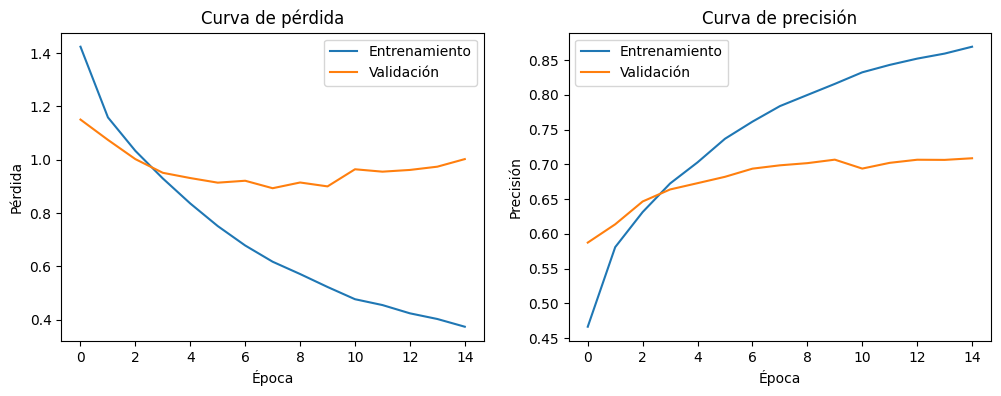

In [194]:
import matplotlib.pyplot as plt


train_loss = historymodelBertCnn.history['loss']
val_loss = historymodelBertCnn.history['val_loss']
train_accuracy = historymodelBertCnn.history['sparse_categorical_accuracy']
val_accuracy = historymodelBertCnn.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [195]:
modelBertCnn.evaluate(test_dataset)

70/70 [==============================] - 71s 914ms/step - loss: 0.9849 - sparse_categorical_accuracy: 0.7098


[0.9848834276199341, 0.7098214030265808]

### Model Bert + NgramCNN + One Layer Attention

In [ ]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Attention

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa de atención
attention = Attention()([sequence_output, sequence_output])

x_1 = layers.Conv1D(filters=50, kernel_size=2, activation="relu", padding="same")(attention)
x_1 = layers.GlobalMaxPooling1D()(x_1)
x_2 = layers.Conv1D(filters=50, kernel_size=3, activation="relu", padding="same")(attention)
x_2 = layers.GlobalMaxPooling1D()(x_2)
x_3 = layers.Conv1D(filters=50, kernel_size=4, activation="relu", padding="same")(attention)
x_3 = layers.GlobalMaxPooling1D()(x_3)

merged = tf.concat([x_1, x_2, x_3], axis=-1)

last_dense = layers.Dense(units=256, activation="relu")(merged)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertCnn2 = Model(inputs=inputs_full, outputs=output)

modelBertCnn2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertCnn2.summary()

### Model Bert + CNN + Attention layers

In [ ]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Attention

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa de atención
attention = Attention()([sequence_output, sequence_output])

x_1 = layers.Conv1D(filters=50, kernel_size=2, activation="relu", padding="same")(attention)
x_1 = Attention()([x_1, x_1])
x_1 = layers.GlobalMaxPooling1D()(x_1)
x_2 = layers.Conv1D(filters=50, kernel_size=3, activation="relu", padding="same")(attention)
x_2 = Attention()([x_2, x_2])
x_2 = layers.GlobalMaxPooling1D()(x_2)
x_3 = layers.Conv1D(filters=50, kernel_size=4, activation="relu", padding="same")(attention)
x_3 = Attention()([x_3, x_3])
x_3 = layers.GlobalMaxPooling1D()(x_3)

merged = tf.concat([x_1, x_2, x_3], axis=-1)

last_dense = layers.Dense(units=256, activation="relu")(merged)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertCnn3 = Model(inputs=inputs_full, outputs=output)

modelBertCnn3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertCnn3.summary()

### Model Bert + BiLSTM

In [ ]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=256, activation="relu")(x)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM.summary()

### Model Bert + BiLStm + Attention layer

In [ ]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Attention

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

attention1 = Attention()([sequence_output, sequence_output])

x = Bidirectional(LSTM(768, return_sequences=True))(attention1)
attention2 = Attention()([x, x])
x = layers.GlobalMaxPooling1D()(attention2)

last_dense = layers.Dense(units=256, activation="relu")(x)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTMAttention = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTMAttention.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTMAttention.summary()

### MODEL BERT + BiLSTM

In [196]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=256, activation="relu")(x)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_27 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_28 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_29 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                            

### MODEL BERT + 2 BiLSTM

In [203]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(64, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=128, activation="relu")(x)
dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3Models2 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_36 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_37 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_38 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                            

In [201]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERT/BiLstm5/64batch', exist_ok=True)


checkpoint_path = 'model/BERT/BiLstm5/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERT/BiLstm5/64batch', exist_ok=True)



log_dir = "logs/BERT/BiLstm5/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodelBertBiLSTM3Models2 =  modelBertBiLSTM3Models2.fit(
    train_dataset,
    epochs=10,
    validation_data = val_dataset,
    callbacks = [model_checkpoint,tensorboard_callback]
)

In [ ]:
import matplotlib.pyplot as plt


train_loss = historymodelBertBiLSTM3Models2.history['loss']
val_loss = historymodelBertBiLSTM3Models2.history['val_loss']
train_accuracy = historymodelBertBiLSTM3Models2.history['sparse_categorical_accuracy']
val_accuracy = historymodelBertBiLSTM3Models2.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### MODEL BERT + 2 BiLSTM - 2

In [286]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Attention
from keras import backend as K
from keras import initializers, regularizers, constraints



inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25))(sequence_output)
x = Attention(use_scale=True)([x, x])
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=128, activation="relu")(x)
dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3Models3 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models3.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_36 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_37 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_38 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                           

### Paper Dual Channel

In [296]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Conv1D, Dropout
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Attention
from keras import backend as K
from keras import initializers, regularizers, constraints



inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])


Layer1 = Bidirectional(LSTM(32, return_sequences=True))(sequence_output)
Layer1 = Conv1D(filters=32, kernel_size=400)(Layer1)
Layer1 = Dropout(0.3)(Layer1)
#Layer1 = Dropout(0.5)(Layer1)

Layer2 = Conv1D(filters=32, kernel_size=400)(sequence_output)
Layer2 = Dropout(0.3)(Layer2)
#Layer2 = Dropout(0.5)(Layer2)
Layer2 = Bidirectional(LSTM(32, return_sequences=True))(Layer2)

x= tf.concat([Layer1,Layer2], axis=-1)
x = layers.MaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
last_dense = layers.Dense(units=512, activation="relu")(x)
#last_dropout = layers.Dropout(0.5)(x)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertDualChannel = Model(inputs=inputs_full, outputs=output)

modelBertDualChannel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [297]:
modelBertDualChannel.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_48 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_49 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_50 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                           

In [298]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('BERT/Model2/modelBertDualChannel/64batch', exist_ok=True)


checkpoint_path = 'BERT/Model2/modelBertDualChannel/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERT/Model2/modelBertDualChannel/64batch', exist_ok=True)



log_dir = "logs/BERT/Model2/modelBertDualChannel/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Alternatives

In [184]:
#from keras import layers
#from keras import Model
#from keras import regularizers

#inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
#input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
#input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
#input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

#pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

#x_1 = layers.Conv1D(filters=50, kernel_size=2, activation="relu", padding="same")(sequence_output)
#x_1 = layers.GlobalMaxPooling1D()(x_1)
#x_2 = layers.Conv1D(filters=50, kernel_size=3, activation="relu", padding="same")(sequence_output)
#x_2 = layers.GlobalMaxPooling1D()(x_2)
#x_3 = layers.Conv1D(filters=50, kernel_size=4, activation="relu", padding="same")(sequence_output)
#x_3 = layers.GlobalMaxPooling1D()(x_3)
#x_4 = layers.Conv1D(filters=50, kernel_size=5, activation="relu", padding="same")(sequence_output)
#x_4 = layers.GlobalMaxPooling1D()(x_4)

#merged = tf.concat([x_1, x_2, x_3, x_4], axis=-1)
#merged = tf.concat([x_1, x_2, x_3], axis=-1)
#dropout = layers.Dropout(0.5)(merged)
#last_dense = layers.Dense(units=256, activation="relu",kernel_regularizer=regularizers.L2(0.01))(dropout)
#dropout = layers.Dropout(0.5)(last_dense)
#output = layers.Dense(units=7, activation="softmax")(dropout)

#modelBertCnn = Model(inputs=inputs_full, outputs=output)

#modelBertCnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

#modelBertCnn.summary()

In [185]:
"""from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Attention
from keras import backend as K
from keras import initializers, regularizers, constraints



inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])


x = Bidirectional(LSTM(768, return_sequences=True, dropout=0.2))(sequence_output)
x = Attention(use_scale=True)([x, x])
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
x = Attention(use_scale=True)([x, x])
#x = Attention(use_scale=True)([x, x])
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=128, activation="relu")(x)
dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3Models4 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models4.summary()"""

'from keras import layers\nfrom keras import Model\nfrom tensorflow.keras.layers import Bidirectional, LSTM\n#from keras_self_attention import SeqSelfAttention\nfrom tensorflow.keras.layers import Attention\nfrom keras import backend as K\nfrom keras import initializers, regularizers, constraints\n\n\n\ninputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name=\'inputs\')\ninput_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\ninput_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\ninput_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\n\nbert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)\n\npooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])\n\n# Aplicar capa bidireccional\nx = Bidirectional(LSTM(768, return_sequences=True, dropout=0.2))(sequence_ou

In [186]:
"""from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=256, activation="relu")(x)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3Models6 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models6.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models6.summary()"""

'from keras import layers\nfrom keras import Model\nfrom tensorflow.keras.layers import Bidirectional, LSTM\n\ninputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name=\'inputs\')\ninput_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\ninput_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\ninput_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\n\nbert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)\n\npooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])\n\n# Aplicar capa bidireccional\nx = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)\nx = layers.GlobalMaxPooling1D()(x)\n\nlast_dense = layers.Dense(units=256, activation="relu")(x)\ndropout = layers.Dropout(0.4)(last_dense)\noutput = layers.Dense(units=7, activation="softmax")(last_d

## Modelos Con Embeddings entrenados

### Tokenización

In [238]:
tokenizerNormal = Tokenizer()
tokenizerNormal.fit_on_texts(texto_clean)
sequences = tokenizerNormal.texts_to_sequences(texto_clean)
sequences

[[328, 1, 2, 3, 330, 135, 19, 7, 10703, 10704, 51, 3, 10705, 5, 10706, 1187],
 [8, 3290, 13, 81, 349, 439],
 [11, 1, 14, 11, 1, 14],
 [32, 472, 140, 4, 159, 557, 49, 81, 1324],
 [126, 670, 2, 409, 4, 327, 1796, 32, 670, 13, 4, 218, 9, 1324],
 [1, 62],
 [42, 6069, 2, 1436, 106, 536, 8, 32, 8, 90, 1619, 4, 352, 979, 19, 103],
 [89, 5, 30],
 [27, 90, 23, 123, 2688],
 [40,
  78,
  99,
  526,
  13,
  4,
  8446,
  491,
  17,
  8,
  19,
  2466,
  42,
  1,
  53,
  1,
  90,
  85,
  18,
  69,
  1410,
  670,
  1013,
  10,
  59,
  100],
 [1006, 8, 90, 1687],
 [348],
 [40, 78, 59],
 [73, 280],
 [94, 1970],
 [94, 94, 94, 8, 365, 93, 146, 102, 11, 1205],
 [73, 2181, 438, 221, 16, 123, 69, 625, 873, 177],
 [90, 1, 22, 4, 1188],
 [94, 14, 8, 353, 4, 665],
 [2, 16, 3, 1971, 122],
 [31, 2, 18, 39, 12, 31, 444, 25, 3291],
 [10707, 7065, 32, 1265, 18, 341, 1380],
 [126, 11, 298, 886, 8, 8, 329, 1265, 202, 1024],
 [14],
 [395, 215, 25, 1079, 2, 19, 7, 725, 757, 32, 1],
 [36],
 [355],
 [355],
 [3472, 14, 16,

In [172]:
df_resampled

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,"Now you'll be heading a whole division, so you...",neutral
...,...,...
44914,"[When my friend, as common, forget the tickets...",angry
44915,[When I was erroneously accused of being a thi...,angry
44916,[I want something to change by reversal come o...,angry
44917,[A father helping his youngster to contend oth...,angry


In [173]:
data_labels[-1]

0

In [102]:
texto_clean[0:10]

["also i be the point person on my company's transition from the kl to gr system.",
 "you must've have your hand full.",
 'that i do. that i do.',
 "so let's talk a little bit about your duty.",
 "now you'll be head a whole division so you'll have a lot of duty.",
 'i see.',
 "but there'll be perhaps people under you so you can dump a certain amount on them.",
 'good to know.',
 'we can go into detail',
 "all right then we'll have a definite answer for you on monday but i think i can say with some confidence you'll fit in well here."]

In [103]:
sequences[0:10]

[[328, 1, 2, 3, 330, 135, 19, 7, 10703, 10704, 51, 3, 10705, 5, 10706, 1187],
 [8, 3290, 13, 81, 349, 439],
 [11, 1, 14, 11, 1, 14],
 [32, 472, 140, 4, 159, 557, 49, 81, 1324],
 [126, 670, 2, 409, 4, 327, 1796, 32, 670, 13, 4, 218, 9, 1324],
 [1, 62],
 [42, 6069, 2, 1436, 106, 536, 8, 32, 8, 90, 1619, 4, 352, 979, 19, 103],
 [89, 5, 30],
 [27, 90, 23, 123, 2688],
 [40,
  78,
  99,
  526,
  13,
  4,
  8446,
  491,
  17,
  8,
  19,
  2466,
  42,
  1,
  53,
  1,
  90,
  85,
  18,
  69,
  1410,
  670,
  1013,
  10,
  59,
  100]]

In [239]:
import random

#Se crea una lista mediante la secuencia, su respectivo label y el largo de la frase.
data_with_len_normal = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(sequences)]


random.shuffle(data_with_len_normal)

#Ordena los datos segun el largo de la secuencia obtenida mediante el len(sent) de la segunda posición
#data_with_len.sort(key=lambda x: x[2])

valor_maximo=-np.inf

for sent_lab in data_with_len_normal:
    if sent_lab[2]>valor_maximo:
        valor_maximo=sent_lab[2]

# Función generadora para el dataset
def generator():
    for sent, label, _ in data_with_len_normal:
        yield tf.constant(sent, dtype=tf.int32), tf.constant(label, dtype=tf.int32)



all_dataset_normal = tf.data.Dataset.from_generator(generator,
                                             output_types=(tf.int32, tf.int32))

# Batch y padding del dataset
BATCH_SIZE_NORMAL = 32
all_batched_normal = all_dataset_normal.padded_batch(BATCH_SIZE_NORMAL,
                                       padded_shapes=([300], []),
                                       padding_values=(0, 0))

In [177]:
data_with_len_normal[0:10]

[[[24, 81, 5847], 5, 3],
 [[29, 12542], 5, 2],
 [[303], 6, 1],
 [[87, 14, 8, 1399], 2, 4],
 [[1, 14, 21, 30, 476], 4, 5],
 [[14, 8, 140, 5, 56], 5, 5],
 [[784, 57, 151], 5, 3],
 [[94], 4, 1],
 [[13917, 2813, 4, 1066, 10, 4, 8156, 375, 18, 4, 2846], 1, 11],
 [[76,
   72,
   2,
   865,
   5578,
   6,
   3202,
   75,
   84,
   456,
   40,
   9,
   4,
   929,
   50,
   1,
   2,
   23,
   144,
   3,
   2707,
   1,
   2,
   400,
   47,
   161,
   1,
   63,
   21,
   256,
   33,
   19,
   3202,
   150,
   3,
   2707,
   6,
   13,
   5,
   2,
   306,
   4378,
   2524,
   17,
   1092,
   16],
  2,
  46]]

In [178]:
for i, element in enumerate(all_batched_normal.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[   24,    81,  5847, ...,     0,     0,     0],
       [   29, 12542,     0, ...,     0,     0,     0],
       [  303,     0,     0, ...,     0,     0,     0],
       ...,
       [   79,     4,  1467, ...,     0,     0,     0],
       [  162,   978,    19, ...,     0,     0,     0],
       [  476,  1654,  1947, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([5, 5, 6, 2, 4, 5, 5, 4, 1, 2, 6, 2, 1, 1, 3, 4, 6, 0, 5, 5, 5, 0,
       3, 3, 2, 2, 6, 2, 3, 0, 1, 0])>)
Elemento 2:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[   1,  112,    4, ...,    0,    0,    0],
       [   1,    2,   41, ...,    0,    0,    0],
       [  88, 2532,    0, ...,    0,    0,    0],
       ...,
       [ 120,    2,  158, ...,    0,    0,    0],
       [ 424,  310,   65, ...,    0,    0,    0],
       [ 291,  284,  284, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([

In [185]:
first = next(iter(all_batched_normal.take(1)))

print(first[0][24])

tf.Tensor(
[  70    1   13  847    5  283    7  117   97   20  234  137    2  473
   50    5   26    1    2   23    5   14   18    7  878  137   14   21
  560    4 6405  317    6  414    1   14   21   46  133   82   63  369
    7  121  236   44 7419   97   20  234    5 1939  150    6 3246   10
    7  244    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [171]:
data_with_len_normal[60:100]

[[[312, 8], 4, 2],
 [[94], 4, 1],
 [[341], 4, 1],
 [[42, 275, 1, 14, 21, 53, 60, 261, 531], 4, 9],
 [[125, 88, 44, 7067, 3292, 2825, 10718, 51, 5346], 4, 9],
 [[32, 148, 186], 4, 3],
 [[59, 59, 5, 2364, 38, 247, 13, 551, 8, 83, 241], 4, 11],
 [[84], 4, 1],
 [[42, 88, 24, 479, 32, 32, 1797, 4, 1469, 5, 7, 980], 4, 12],
 [[77], 4, 1],
 [[8, 14, 21, 53, 25, 2, 184, 801], 4, 8],
 [[211, 90, 1, 140, 5, 8, 17, 4, 464], 4, 9],
 [[197, 322, 32, 315, 23, 19], 4, 6],
 [[94, 8, 348], 4, 3],
 [[66, 2, 8449, 66, 2, 171, 404, 11, 1, 53, 16, 2, 55, 5, 271, 16, 18, 233],
  4,
  18],
 [[1, 185, 5, 346, 11, 1, 2, 13, 282, 17, 162, 269], 4, 12],
 [[348, 1620, 179, 80, 9, 3, 4803, 8, 30, 26, 164, 5, 3, 10719, 4359], 4, 15],
 [[36, 1860, 3715, 247, 325, 9, 10, 3, 589, 9, 4, 770, 100], 4, 13],
 [[73, 90, 8, 122, 35, 356, 56, 10, 3, 2967, 338], 4, 11],
 [[1, 91, 247, 3293, 78], 4, 5],
 [[36, 73, 1688, 85, 66, 468, 2, 5347, 1300], 4, 9],
 [[73, 656, 11, 132, 31, 13, 4, 77, 243, 627], 4, 10],
 [[82, 8, 85, 243

In [127]:
len(data_with_len_normal)

44919

In [240]:
import math

# Calcular el número total de lotes
NB_BATCHES = math.ceil(len(data_with_len_normal) / BATCH_SIZE)
print("NB_BATCHES totales: ",NB_BATCHES)

# Calcular el número de lotes para validación y prueba
NB_BATCHES_VAL = (NB_BATCHES * 20) // 100
NB_BATCHES_TEST = (NB_BATCHES * 10) // 100
print("NB_BATCHES validacion: ",NB_BATCHES_VAL)
print("NB_BATCHES testeo: ",NB_BATCHES_TEST)
print("NB_BATCHES entrenamiento", NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL))

# Se crea los conjuntos de datos para entrenamiento, validación y prueba
val_dataset_normal = all_batched_normal.take(NB_BATCHES_VAL)
test_dataset_normal = all_batched_normal.skip(NB_BATCHES_VAL).take(NB_BATCHES_TEST)
train_dataset_normal = all_batched_normal.skip(NB_BATCHES_VAL + NB_BATCHES_TEST) 

BUFFER_SIZE = 10000  
train_dataset_normal = train_dataset_normal.shuffle(BUFFER_SIZE)



NB_BATCHES totales:  1404
NB_BATCHES validacion:  280
NB_BATCHES testeo:  140
NB_BATCHES entrenamiento 984


In [241]:
print(len(list(val_dataset_normal)))
print(len(list(test_dataset_normal)))
print(len(list(train_dataset_normal)))

280
140
984


In [191]:
for i, element in enumerate(val_dataset_normal.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[   24,    81,  5847, ...,     0,     0,     0],
       [   29, 12542,     0, ...,     0,     0,     0],
       [  303,     0,     0, ...,     0,     0,     0],
       ...,
       [   79,     4,  1467, ...,     0,     0,     0],
       [  162,   978,    19, ...,     0,     0,     0],
       [  476,  1654,  1947, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([5, 5, 6, 2, 4, 5, 5, 4, 1, 2, 6, 2, 1, 1, 3, 4, 6, 0, 5, 5, 5, 0,
       3, 3, 2, 2, 6, 2, 3, 0, 1, 0])>)
Elemento 2:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[   1,  112,    4, ...,    0,    0,    0],
       [   1,    2,   41, ...,    0,    0,    0],
       [  88, 2532,    0, ...,    0,    0,    0],
       ...,
       [ 120,    2,  158, ...,    0,    0,    0],
       [ 424,  310,   65, ...,    0,    0,    0],
       [ 291,  284,  284, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([

In [190]:
for i, element in enumerate(train_dataset_normal.take(30)):
    print(f"Elemento {i+1}:")
    print(element)


Elemento 1:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[  70,   13,    2, ...,    0,    0,    0],
       [   8,  192,   21, ...,    0,    0,    0],
       [  12,    1,  283, ...,    0,    0,    0],
       ...,
       [   1,   91,    8, ...,    0,    0,    0],
       [   2,   98,   20, ...,    0,    0,    0],
       [  12,    1, 1250, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([5, 0, 5, 6, 2, 2, 6, 0, 6, 6, 4, 4, 6, 4, 5, 2, 0, 4, 2, 0, 3, 0,
       1, 5, 1, 4, 1, 6, 2, 5, 1, 1])>)
Elemento 2:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[ 852, 3029,  150, ...,    0,    0,    0],
       [ 178,    3,  857, ...,    0,    0,    0],
       [  78,   32,    3, ...,    0,    0,    0],
       ...,
       [   6, 2625, 4245, ...,    0,    0,    0],
       [  12,    1,  283, ...,    0,    0,    0],
       [   4, 1656,    9, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 5, 4, 4, 6, 5, 6, 3, 5, 1, 0, 6, 

In [242]:
maximo_largo =300 #Maximo largo de la secuencia
vocab_size = len(tokenizerNormal.word_index) + 1
vocab_size

15114

In [243]:
vocab = tokenizerNormal.word_index
vocab

{'i': 1,
 'be': 2,
 'the': 3,
 'a': 4,
 'to': 5,
 'and': 6,
 'my': 7,
 'you': 8,
 'of': 9,
 'in': 10,
 'that': 11,
 'when': 12,
 'have': 13,
 'do': 14,
 'me': 15,
 'it': 16,
 'for': 17,
 'with': 18,
 'on': 19,
 'at': 20,
 "n't": 21,
 'get': 22,
 'go': 23,
 'not': 24,
 'this': 25,
 'what': 26,
 'we': 27,
 'one': 28,
 'no': 29,
 'know': 30,
 'he': 31,
 'so': 32,
 'out': 33,
 'friend': 34,
 'just': 35,
 'oh': 36,
 'she': 37,
 'up': 38,
 'her': 39,
 'all': 40,
 'very': 41,
 'but': 42,
 'come': 43,
 'an': 44,
 'like': 45,
 'make': 46,
 'by': 47,
 'information': 48,
 'about': 49,
 'as': 50,
 'from': 51,
 'they': 52,
 'think': 53,
 'would': 54,
 'time': 55,
 'him': 56,
 "i'm": 57,
 'state': 58,
 'well': 59,
 "it's": 60,
 'want': 61,
 'see': 62,
 'could': 63,
 'his': 64,
 'take': 65,
 'there': 66,
 'because': 67,
 'technology': 68,
 'some': 69,
 'after': 70,
 'tell': 71,
 'number': 72,
 'yeah': 73,
 'who': 74,
 'felt': 75,
 'atomic': 76,
 'really': 77,
 'right': 78,
 "you're": 79,
 'day': 80,


### Word2Vec concatenado con FastText

In [244]:
texto_clean_split = [text.split() for text in texto_clean]
texto_clean_split

[['also',
  'i',
  'be',
  'the',
  'point',
  'person',
  'on',
  'my',
  "company's",
  'transition',
  'from',
  'the',
  'kl',
  'to',
  'gr',
  'system.'],
 ['you', "must've", 'have', 'your', 'hand', 'full.'],
 ['that', 'i', 'do.', 'that', 'i', 'do.'],
 ['so', "let's", 'talk', 'a', 'little', 'bit', 'about', 'your', 'duty.'],
 ['now',
  "you'll",
  'be',
  'head',
  'a',
  'whole',
  'division',
  'so',
  "you'll",
  'have',
  'a',
  'lot',
  'of',
  'duty.'],
 ['i', 'see.'],
 ['but',
  "there'll",
  'be',
  'perhaps',
  'people',
  'under',
  'you',
  'so',
  'you',
  'can',
  'dump',
  'a',
  'certain',
  'amount',
  'on',
  'them.'],
 ['good', 'to', 'know.'],
 ['we', 'can', 'go', 'into', 'detail'],
 ['all',
  'right',
  'then',
  "we'll",
  'have',
  'a',
  'definite',
  'answer',
  'for',
  'you',
  'on',
  'monday',
  'but',
  'i',
  'think',
  'i',
  'can',
  'say',
  'with',
  'some',
  'confidence',
  "you'll",
  'fit',
  'in',
  'well',
  'here.'],
 ['absolutely.', 'you', 

In [245]:
import gensim

In [246]:
DIM = 300 #maximo largo de la secuencia
maxlen=300
w2v_model = gensim.models.Word2Vec(sentences=texto_clean_split, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado Word2vec
fasttext_model = gensim.models.FastText(sentences=texto_clean_split, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado FastText
#Tiene que aparecer una vez como minimo en la secuencia para considerarlo

w2v_model

In [ ]:
w2v_model.wv['meaning']

In [247]:
import numpy as np

def get_weights_matrix_embedding_word2vec(model_w2v, fasttext_model):

    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo
    for word, index in vocab.items():
      try:
        weights_matrix[index] = model_w2v.wv[word] #obtiene los pesos de la palabra del modelo word2vec
      except KeyError:
        weights_matrix[index] = fasttext_model.wv[word] #En caso de que no exista en el vocabulario de Word2Vec ocupa FastText


    return weights_matrix

In [248]:
#Creación del embedding, donde ingresa cada palabra al modelo y retorna los pesos
Embeddings_Word2Vec_FastText = get_weights_matrix_embedding_word2vec(w2v_model, fasttext_model)

In [249]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[Embeddings_Word2Vec_FastText], input_length=maximo_largo_secuencias, trainable=False)(input_seq)
lstm1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
dropout = Dropout(0.5)(lstm1)
lstm2 = Bidirectional(LSTM(128))(dropout)
dense = Dense(32)(lstm2)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmWord2Vec = Model(inputs=input_seq, outputs=output)

modelBiLstmWord2Vec.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmWord2Vec.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 300, 300)          4534200   
                                                                 
 bidirectional_26 (Bidirecti  (None, 300, 256)         439296    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 300, 256)          0         
                                                                 
 bidirectional_27 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_30 (Dense)            (None, 32)                822

In [250]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('Embeddings/Word2Vec_FastText/BiLstm/64batch', exist_ok=True)


checkpoint_path = 'Embeddings/Word2Vec_FastText/BiLstm/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/Embeddings/Word2Vec_FastText/BiLstm/64batch', exist_ok=True)



log_dir = "logs/Embeddings/Word2Vec_FastText/BiLstm/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [251]:
historyWord2Vec = modelBiLstmWord2Vec.fit(
    train_dataset_normal,
    validation_data=val_dataset_normal,
    epochs=15,
    callbacks=[model_checkpoint, tensorboard_callback]
) 

Epoch 1/15
    984/Unknown - 327s 173ms/step - loss: 1.6092 - sparse_categorical_accuracy: 0.3625
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.40714, saving model to Embeddings/Word2Vec_FastText/BiLstm/64batch\best_model_modelLSTM_1_0.4071.h5
984/984 [==============================] - 384s 231ms/step - loss: 1.6092 - sparse_categorical_accuracy: 0.3625 - val_loss: 1.5070 - val_sparse_categorical_accuracy: 0.4071
Epoch 2/15
984/984 [==============================] - ETA: 0s - loss: 1.4643 - sparse_categorical_accuracy: 0.4375
Epoch 2: val_sparse_categorical_accuracy improved from 0.40714 to 0.45882, saving model to Embeddings/Word2Vec_FastText/BiLstm/64batch\best_model_modelLSTM_2_0.4588.h5
984/984 [==============================] - 286s 211ms/step - loss: 1.4643 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.4129 - val_sparse_categorical_accuracy: 0.4588
Epoch 3/15
984/984 [==============================] - ETA: 0s - loss: 1.3559 - sparse_categorical_accuracy: 

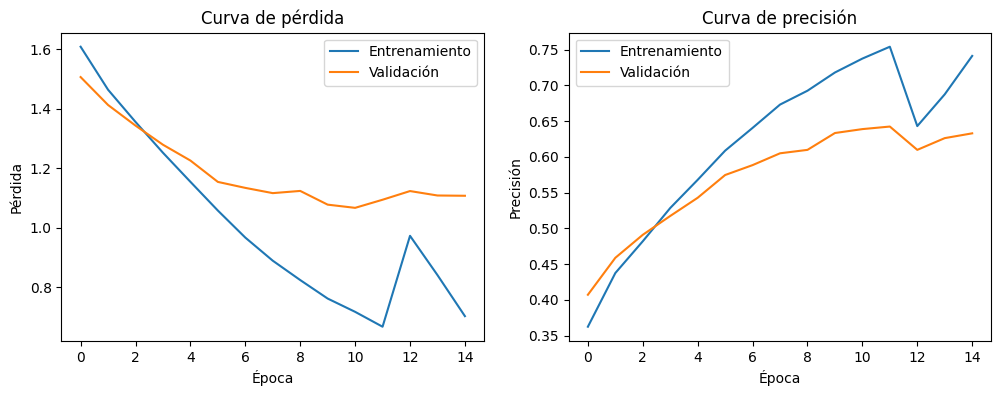

In [252]:
import matplotlib.pyplot as plt


train_loss = historyWord2Vec.history['loss']
val_loss = historyWord2Vec.history['val_loss']
train_accuracy = historyWord2Vec.history['sparse_categorical_accuracy']
val_accuracy = historyWord2Vec.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Word2Vec + FastText separados

In [253]:
DIM = 300 #maximo largo de la secuencia
maxlen=300
w2v_model = gensim.models.Word2Vec(sentences=texto_clean_split, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado Word2vec
fasttext_model = gensim.models.FastText(sentences=texto_clean_split, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado FastText
#Tiene que aparecer una vez como minimo en la secuencia para considerarlo

w2v_model

In [254]:
import numpy as np

def get_weights_matrix_embedding_word2vecFastText(model_w2v, fasttext_model):

    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo
    for word, index in vocab.items():
      try:
        weights_matrix[index] = model_w2v.wv[word] #obtiene los pesos de la palabra del modelo word2vec
      except KeyError:
        weights_matrix[index] = fasttext_model.wv[word] #en caso de no estar en el vocabulario de word2Vec ocupa FastText


    return weights_matrix


def get_weights_matrix_embedding(model):
    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo

    for word, index in vocab.items():
        weights_matrix[index] = model.wv[word] #obtiene los pesos de la palabra del modelo wor2vec

    return weights_matrix

In [255]:
#Creación del embedding, donde ingresa cada palabra al modelo y retorna los pesos
EmbeddingsW2Vec = get_weights_matrix_embedding_word2vecFastText(w2v_model, fasttext_model) #Pesos para Word2Vec con complemento de FastText
EmbeddingsFastText = get_weights_matrix_embedding(fasttext_model) #Pesos para FastText

In [256]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, concatenate, Dropout
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_word2vec = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[EmbeddingsW2Vec], input_length=maximo_largo_secuencias, trainable=False)(input_seq)
embedding_fasttext = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[EmbeddingsFastText], input_length=maximo_largo_secuencias, trainable=False)(input_seq)

lstm_word2vec = Bidirectional(LSTM(128))(embedding_word2vec)
dropout_word2vec = Dropout(0.5)(lstm_word2vec)

lstm_fasttext = Bidirectional(LSTM(128))(embedding_fasttext)
dropout_fastText = Dropout(0.5)(lstm_fasttext)


concatenated = concatenate([dropout_word2vec, dropout_fastText])

dense = Dense(32)(concatenated)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmWord2VecFastText = Model(inputs=input_seq, outputs=output)

modelBiLstmWord2VecFastText.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmWord2VecFastText.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 300, 300)     4534200     ['input_6[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, 300, 300)     4534200     ['input_6[0][0]']                
                                                                                                  
 bidirectional_28 (Bidirectiona  (None, 256)         439296      ['embedding_5[0][0]']            
 l)                                                                                        

In [257]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('Embeddings/Word2VecSeparadoFastText/BiLstm/64batch', exist_ok=True)


checkpoint_path = 'Embeddings/Word2VecSeparadoFastText/BiLstm/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/Embeddings/Word2VecSeparadoFastText/BiLstm/64batch', exist_ok=True)



log_dir = "logs/Embeddings/Word2VecSeparadoFastText/BiLstm/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [258]:
historyWord2VecFastText = modelBiLstmWord2VecFastText.fit(
    train_dataset_normal,
    validation_data=val_dataset_normal,
    epochs=15,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/15
    984/Unknown - 346s 187ms/step - loss: 1.6241 - sparse_categorical_accuracy: 0.3571
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.40156, saving model to Embeddings/Word2VecSeparadoFastText/BiLstm/64batch\best_model_modelLSTM_1_0.4016.h5
984/984 [==============================] - 399s 241ms/step - loss: 1.6241 - sparse_categorical_accuracy: 0.3571 - val_loss: 1.5286 - val_sparse_categorical_accuracy: 0.4016
Epoch 2/15
984/984 [==============================] - ETA: 0s - loss: 1.5136 - sparse_categorical_accuracy: 0.4129
Epoch 2: val_sparse_categorical_accuracy improved from 0.40156 to 0.43705, saving model to Embeddings/Word2VecSeparadoFastText/BiLstm/64batch\best_model_modelLSTM_2_0.4371.h5
984/984 [==============================] - 294s 218ms/step - loss: 1.5136 - sparse_categorical_accuracy: 0.4129 - val_loss: 1.4518 - val_sparse_categorical_accuracy: 0.4371
Epoch 3/15
984/984 [==============================] - ETA: 0s - loss: 1.4398 - sparse_categori

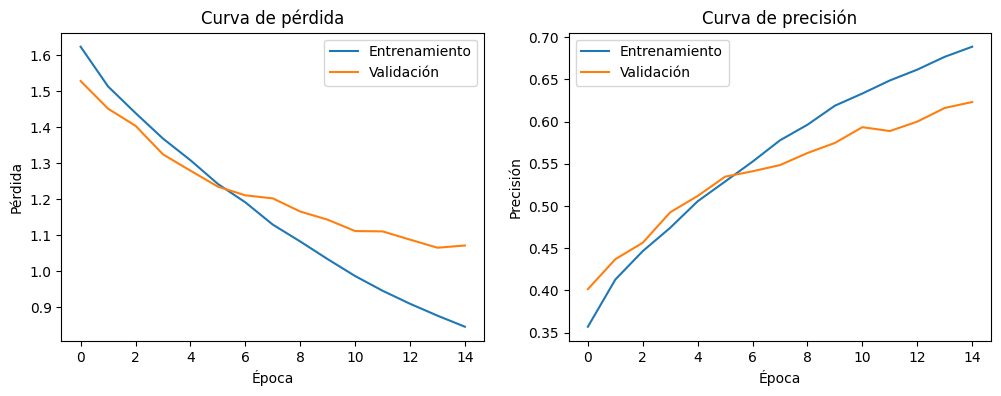

In [259]:
import matplotlib.pyplot as plt


train_loss = historyWord2VecFastText.history['loss']
val_loss = historyWord2VecFastText.history['val_loss']
train_accuracy = historyWord2VecFastText.history['sparse_categorical_accuracy']
val_accuracy = historyWord2VecFastText.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Glove

In [194]:
embedding_dictionary = dict()

glove_file = open('glove.6B.300d.txt', encoding='utf-8')
for linea in glove_file:
    values = linea.split()
    word = values[0]
    vector_dimensiones = np.asarray(values[1:], dtype="float32") #se obtiene el vector de pesos
    embedding_dictionary[word] = vector_dimensiones #a cada palabra se define el vector de pesos
glove_file.close()

In [196]:
def obtener_pesos_matrix_para_cada_palabra(call_model):
    weights_matrix = np.zeros((vocab_size, maximo_largo))

    for word, index in tokenizer.word_index.items():
        embedding_vector = call_model.get(word) #se transforma y se obtiene la matriz de pesos

        if embedding_vector is not None:
            weights_matrix[index] = embedding_vector
    return weights_matrix

In [213]:
Embeddings_Glove = obtener_pesos_matrix_para_cada_palabra(embedding_dictionary)

In [218]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model



input_seq  = Input(shape=(maximo_largo,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo, weights=[Embeddings_Glove], input_length=maximo_largo, trainable=False)(input_seq)
lstm1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25))(embedding_layer)
lstm2 = Bidirectional(LSTM(128, dropout=0.25))(lstm1)
dense = Dense(128)(lstm2)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmGlove = Model(inputs=input_seq, outputs=output)

modelBiLstmGlove.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmGlove.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 300)          4534200   
                                                                 
 bidirectional_23 (Bidirecti  (None, 300, 512)         1140736   
 onal)                                                           
                                                                 
 bidirectional_24 (Bidirecti  (None, 256)              656384    
 onal)                                                           
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0  